In [1]:
### Autonomous GenAI Agent for Proactive Threat Hunting 
# (Kaggle Open-Source Only Version) 
#
# Leverages LangGraph for stateful, multi-step reasoning and tool use in a
# simulated cybersecurity threat hunting scenario.

# Constraint Checklist & Modifications:
# [X] Runs in Kaggle Jupyter Notebook environment.
# [X] Uses only open-source libraries.
# [X] No Vertex AI.
# [X] No Google Cloud SDKs (beyond google-api-python-client used by google-genai).
# [X] No other paid Google services. Using standard Gemini API via langchain-google-genai.
# [X] Grounding replaced with open-source web search tool (DuckDuckGo).


In [2]:
### 1. Setup and Installation

# Install necessary packages, including LangGraph, LangChain components, ChromaDB,
# Google Generative AI, Pandas, and LangChain Community for web search.

!pip install --upgrade --quiet "langgraph>=0.0.50" "langchain-google-genai>=1.0.3" \
"langchain-core>=0.1.40" "langchain-community>=0.0.38" "chromadb>=0.5.0" \
"google-api-python-client" "google-auth" "duckduckgo-search" \
"kaggle" "ipython" "ipykernel" "typing_extensions" "python-dotenv" \
"pandas>=2.0.0" "scikit-learn"

print("Package installation/update complete.")
print("Please RESTART the kernel if you installed/updated packages.\nIf you already restarted after a previous run of this cell, you can ignore this.")


Package installation/update complete.
Please RESTART the kernel if you installed/updated packages.
If you already restarted after a previous run of this cell, you can ignore this.


In [3]:
### 2. Imports
import os
import json
import logging
import re
import datetime
import pandas as pd
from typing import List, Dict, Any, Optional, Annotated, Literal, TypedDict

# For async operations
import asyncio
import ipaddress # For robust IP address checking

# LangGraph & LangChain
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, BaseMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

# LangChain Community Tools (for Web Search)
from langchain_community.tools import DuckDuckGoSearchRun

# Google Generative AI (Embeddings & LLM API)
import google.generativeai as genai
from google.api_core import retry
from google.api_core import exceptions as api_core_exceptions

# ChromaDB
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
# For potential future use with ChromaDB batching if adding docs dynamically
# from chromadb.utils.batch_utils import create_batches


# Other Utilities
from IPython.display import Markdown, display, Image
import time

# Use Kaggle secrets or dotenv for local development
_use_kaggle_secrets = False
try:
 from kaggle_secrets import UserSecretsClient
 _use_kaggle_secrets = True
 print("Attempting to use Kaggle secrets.")
except ImportError:
 try:
  from dotenv import load_dotenv
  load_dotenv() # Load .env file if it exists
  _use_kaggle_secrets = False
  print("Kaggle secrets not found, attempting to load from .env file for local development.")
 except ImportError:
  _use_kaggle_secrets = False
  print("Kaggle secrets and python-dotenv not found. Please ensure GOOGLE_API_KEY is set manually as an environment variable.")

print("Imports complete.")


Attempting to use Kaggle secrets.
Imports complete.


In [4]:
### 3. Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('threat_hunter_agent_oss_optimized')
logger.info("Logging setup complete.")


In [5]:
### 4. API Key Configuration

GOOGLE_API_KEY = None

if _use_kaggle_secrets:
 try:
  secrets = UserSecretsClient()
  GOOGLE_API_KEY = secrets.get_secret("GOOGLE_API_KEY")
  logger.info("Successfully retrieved GOOGLE_API_KEY from Kaggle secrets.")
 except Exception as e:
  logger.error(f"Failed to get GOOGLE_API_KEY from Kaggle secret: {e}")
else:
 GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
 if GOOGLE_API_KEY:
  logger.info("Using GOOGLE_API_KEY from environment variable.")
 else:
  logger.warning("GOOGLE_API_KEY not found in environment variables (expected if not using Kaggle secrets).")

if not GOOGLE_API_KEY:
 logger.error("CRITICAL: GOOGLE_API_KEY not found. The agent cannot function without it. Please set it in Kaggle secrets or as an environment variable.")
 print("ERROR: GOOGLE_API_KEY not found. Cannot proceed with LLM and Embedding functionalities.")
else:
 try:
  genai.configure(api_key=GOOGLE_API_KEY)
  os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY # For LangChain to pick up
  logger.info("Google Generative AI client configured and environment variable set for LangChain.")
 except Exception as e:
  logger.error(f"Error configuring Google Generative AI API key: {e}")
  print(f"Error configuring API key: {e}")
  GOOGLE_API_KEY = None # Ensure it's None if setup fails


In [6]:
### 5. Gemini Embedding Function for ChromaDB
# This function remains synchronous as ChromaDB's client typically expects a sync embedding function,
# and google.generativeai.embed_content is synchronous.
class GeminiEmbeddingFunction(EmbeddingFunction):
 """Custom embedding function using Gemini API (text-embedding-004)"""
 def __init__(self, api_key: Optional[str] = None, task_type="retrieval_document", model_name="models/text-embedding-004"):
  # API key configuration is now handled globally.
  # We can assert that GOOGLE_API_KEY is set before instantiation if needed,
  # or rely on genai.configure() having been called.
  self.task_type = task_type
  self.model_name = model_name
  logger.info(f"GeminiEmbeddingFunction initialized with model: {self.model_name}, task_type: {self.task_type}")

 @retry.Retry(predicate=retry.if_exception_type(
  api_core_exceptions.Aborted,
  api_core_exceptions.DeadlineExceeded,
  api_core_exceptions.ServiceUnavailable,
  api_core_exceptions.InternalServerError,
  ConnectionError, # Added ConnectionError
  api_core_exceptions.ResourceExhausted # Added common API limit error
 ))
 def __call__(self, input: Documents) -> Embeddings:
  """Embeds a list of documents."""
  if not GOOGLE_API_KEY: # Check if API key was successfully configured
   logger.error("GeminiEmbeddingFunction: GOOGLE_API_KEY not configured.")
   raise ValueError("GOOGLE_API_KEY not configured for embedding.")
  if not input:
   return []

  current_task_type = self.task_type
  try:
   if not isinstance(input, list) or not all(isinstance(doc, str) for doc in input):
    raise TypeError("Input must be a list of strings (Documents).")

   response = genai.embed_content(
    model=self.model_name,
    content=input,
    task_type=current_task_type
   )

   if 'embedding' in response and isinstance(response['embedding'], list):
    embeddings = response['embedding']
    if embeddings and not isinstance(embeddings[0], list) and len(input) == 1:
     return [embeddings]
    else:
     return embeddings
   else:
    logger.error(f"Unexpected embedding response format: {response}")
    raise ValueError("Failed to extract embeddings from response.")
  except TypeError as te:
   logger.error(f"Input type error during embedding: {te}")
   raise
  except Exception as e:
   logger.exception(f"Error during embedding call: {e}")
   raise ValueError(f"Embedding failed: {e}")


In [7]:
### 6. Simulated Security Data Definition
web_log_data = {
 'timestamp': pd.to_datetime(['2024-03-15 10:01:23', '2024-03-15 10:05:01', '2024-03-15 10:05:05', '2024-03-15 10:06:11', '2024-03-15 10:08:45', '2024-03-15 10:15:30', '2024-03-15 10:15:32', '2024-03-15 10:15:40', '2024-03-15 10:20:05']),
 'source_ip': ['192.168.1.101', '10.0.0.55', '203.0.113.15', '10.0.0.55', '198.51.100.88', '172.16.10.20', '203.0.113.15', '172.16.10.20', '192.0.2.140'],
 'method': ['GET', 'GET', 'POST', 'GET', 'GET', 'POST', 'GET', 'POST', 'PUT'],
 'uri': ['/index.html', '/login', '/api/users', '/images/logo.png', '/robots.txt', '/admin/config', '/api/products?id=1 UNION SELECT password FROM users--', '/admin/update', '/files/upload.php'],
 'protocol': ['HTTP/1.1'] * 9,
 'status_code': [200, 200, 401, 200, 404, 403, 500, 200, 403],
 'user_agent': ['Chrome/99', 'Firefox/98', 'curl/7.68', 'Firefox/98', 'Nmap Scanner', 'Python-requests/2.27', 'sqlmap/1.6', 'Python-requests/2.27', 'Go-http-client/1.1']
}
df_web_logs = pd.DataFrame(web_log_data)
logger.info(f"Created simulated web log DataFrame with {len(df_web_logs)} entries.")

auth_log_data = {
 'timestamp': pd.to_datetime(['2024-03-15 09:30:00', '2024-03-15 09:35:10', '2024-03-15 09:35:11', '2024-03-15 09:35:12', '2024-03-15 09:40:05', '2024-03-15 10:05:01', '2024-03-15 10:15:30', '2024-03-15 10:20:05']),
 'user': ['j.doe', 'admin', 'admin', 'admin', 'm.smith', 'guest_user', 'service_acct', 'root'],
 'source_ip': ['192.168.1.101', '10.0.0.55', '10.0.0.55', '10.0.0.55', '203.0.113.15', '10.0.0.55', '172.16.10.20', '192.0.2.140'],
 'event_type': ['login_success', 'login_failed', 'login_failed', 'login_failed', 'login_success', 'login_failed', 'login_success', 'login_failed'],
 'hostname': ['workstation-01', 'webserver-prod', 'webserver-prod', 'webserver-prod', 'vpn-gw', 'webserver-prod', 'appserver-01', 'db-server-critical']
}
df_auth_logs = pd.DataFrame(auth_log_data)
logger.info(f"Created simulated auth log DataFrame with {len(df_auth_logs)} entries.")

SIMULATED_DATA_SOURCES = {
 "web_logs": df_web_logs,
 "auth_logs": df_auth_logs
}

mitre_attack_data = [
 {"id": "T1190", "name": "Exploit Public-Facing Application", "description": "Adversaries may attempt to exploit weaknesses in internet-facing systems like web servers, leveraging vulnerabilities like SQL injection (T1190 maps to SQLi via sub-technique T1595.005), cross-site scripting, or misconfigurations to gain initial access or elevate privileges.", "tactics": ["Initial Access", "Privilege Escalation"]},
 {"id": "T1078", "name": "Valid Accounts", "description": "Adversaries may obtain and abuse credentials of existing accounts (users, admins, service accounts) to bypass access controls and operate within a network. This can be achieved through credential dumping, phishing, or brute force.", "tactics": ["Defense Evasion", "Persistence", "Privilege Escalation", "Initial Access"]},
 {"id": "T1059.003", "name": "Command and Scripting Interpreter: Windows Command Shell", "description": "Adversaries may abuse the Windows Command Shell (cmd.exe) for execution. Cmd.exe is the default command-line interpreter for Windows.", "tactics": ["Execution"]},
 {"id": "T1566", "name": "Phishing", "description": "Adversaries may send phishing messages to users to gain access to accounts or systems. This often involves tricking users into revealing credentials or executing malicious code.", "tactics": ["Initial Access", "Reconnaissance"]},
 {"id": "T1219", "name": "Remote Access Software", "description": "Adversaries may use legitimate remote access software (e.g., TeamViewer, AnyDesk) to maintain persistence or control over victim systems.", "tactics": ["Command and Control", "Persistence"]},
 {"id": "T1486", "name": "Data Encrypted for Impact", "description": "Adversaries encrypt data on target systems or networks, rendering it unusable without a decryption key, commonly known as ransomware.", "tactics": ["Impact"]},
]
mitre_docs = [f"MITRE ATT&CK ID: {t['id']}. Name: {t['name']}. Description: {t['description']} Tactics: {', '.join(t['tactics'])}." for t in mitre_attack_data]
logger.info(f"Generated {len(mitre_docs)} MITRE ATT&CK descriptions for RAG.")


In [8]:
### 7. ChromaDB Setup for RAG (MITRE ATT&CK)
DB_PATH_MITRE = "./chroma_db_threat_hunter_mitre_oss" # Use distinct path
COLLECTION_NAME_MITRE = "mitre_attack_techniques_oss"
db_mitre = None # Initialize

if GOOGLE_API_KEY:
    try:
        embed_fn_mitre = GeminiEmbeddingFunction(api_key=GOOGLE_API_KEY, task_type="retrieval_document")
        chroma_client_mitre = chromadb.PersistentClient(path=DB_PATH_MITRE)
        db_mitre = chroma_client_mitre.get_or_create_collection(
            name=COLLECTION_NAME_MITRE,
            embedding_function=embed_fn_mitre,
            metadata={"hnsw:space": "cosine"}
        )
        logger.info(f"ChromaDB collection '{COLLECTION_NAME_MITRE}' created or retrieved from path '{DB_PATH_MITRE}'.")

        # Add MITRE descriptions if collection is empty
        if db_mitre.count() == 0 and mitre_docs:
            logger.info(f"Adding {len(mitre_docs)} MITRE ATT&CK documents to ChromaDB...")
            mitre_ids = [t['id'] for t in mitre_attack_data]
            mitre_metadatas = [{"name": t['name'], "tactics": ", ".join(t['tactics'])} for t in mitre_attack_data]

            # Batch add for efficiency
            batch_size = 100 # Adjust as needed
            for i in range(0, len(mitre_docs), batch_size):
                batch_docs_chunk = mitre_docs[i:i+batch_size]
                batch_ids_chunk = mitre_ids[i:i+batch_size]
                batch_metadatas_chunk = mitre_metadatas[i:i+batch_size]
                db_mitre.add(documents=batch_docs_chunk, ids=batch_ids_chunk, metadatas=batch_metadatas_chunk)
                logger.info(f"Added batch {i//batch_size + 1} to ChromaDB.")
                time.sleep(0.5) # Small delay between batches

            logger.info("MITRE ATT&CK documents added successfully.")
            time.sleep(1) # Allow persistence
        else:
            logger.info(f"Collection '{COLLECTION_NAME_MITRE}' already contains {db_mitre.count()} documents. Skipping add.")

        # Verification
        if db_mitre.count() > 0:
            logger.info(f"ChromaDB for MITRE ATT&CK setup successful. Count: {db_mitre.count()}")
        else:
            logger.warning("ChromaDB MITRE collection appears empty after potential add operation.")

        # --- Inspect ChromaDB Collection ---
        if db_mitre:
            print(f"\nInspecting ChromaDB Collection: {COLLECTION_NAME_MITRE}")
            collection_count = db_mitre.count()
            print(f"Total documents in collection: {collection_count}")
            
            if collection_count > 0:
                print(f"Attempting to retrieve all items for inspection...")
                # Corrected .get() call: remove 'limit' and 'ids' from 'include'
                # 'ids' are returned by default in the 'ids' key of the result.
                retrieved_data = db_mitre.get(
                    include=['documents', 'metadatas'] 
                )
                
                if retrieved_data and retrieved_data.get('ids'):
                    ids = retrieved_data.get('ids', [])
                    documents = retrieved_data.get('documents', [])
                    metadatas = retrieved_data.get('metadatas', [])
                    
                    sample_to_print = 5 # How many items to print as a sample
                    num_items_retrieved = len(ids)
                    
                    print(f"\n--- Sample of Retrieved Data (up to first {min(sample_to_print, num_items_retrieved)} of {num_items_retrieved} items) ---")
                    
                    for i in range(min(sample_to_print, num_items_retrieved)):
                        print(f"\nID: {ids[i]}")
                        if metadatas and i < len(metadatas) and metadatas[i]:
                            print(f"  Metadata: {metadatas[i]}")
                        if documents and i < len(documents) and documents[i]:
                            print(f"  Document: {documents[i][:300]}...") # Print first 300 chars
                        print("-" * 20)
                else:
                    print("No data retrieved from the collection (get call returned empty or no IDs).")
            else:
                print("Collection is empty, nothing to inspect.")
        else:
            print("\nChromaDB collection 'db_mitre' was not successfully initialized for inspection (remains None).")

    except Exception as e:
        logger.exception(f"Failed to setup or inspect ChromaDB for MITRE ATT&CK: {e}")
        db_mitre = None # Ensure db_mitre is None if any error occurs
        print(f"ERROR: Failed to setup or inspect ChromaDB for MITRE ATT&CK: {e}")
else:
    logger.error("Cannot setup or inspect ChromaDB for MITRE: GOOGLE_API_KEY is missing.")
    print("ERROR: Cannot setup or inspect ChromaDB for MITRE: GOOGLE_API_KEY is missing.")


Inspecting ChromaDB Collection: mitre_attack_techniques_oss
Total documents in collection: 6
Attempting to retrieve all items for inspection...

--- Sample of Retrieved Data (up to first 5 of 6 items) ---

ID: T1190
  Metadata: {'name': 'Exploit Public-Facing Application', 'tactics': 'Initial Access, Privilege Escalation'}
  Document: MITRE ATT&CK ID: T1190. Name: Exploit Public-Facing Application. Description: Adversaries may attempt to exploit weaknesses in internet-facing systems like web servers, leveraging vulnerabilities like SQL injection (T1190 maps to SQLi via sub-technique T1595.005), cross-site scripting, or misconfigu...
--------------------

ID: T1078
  Metadata: {'name': 'Valid Accounts', 'tactics': 'Defense Evasion, Persistence, Privilege Escalation, Initial Access'}
  Document: MITRE ATT&CK ID: T1078. Name: Valid Accounts. Description: Adversaries may obtain and abuse credentials of existing accounts (users, admins, service accounts) to bypass access controls and opera

In [9]:
### 8. RAG Search Function (Adapted for MITRE) - Now Asynchronous
async def search_mitre_attack_rag(query: str, n_results: int = 3) -> Optional[List[str]]:
 """Searches the MITRE ATT&CK vector database for relevant techniques asynchronously."""
 if db_mitre is None:
  logger.error("MITRE ATT&CK ChromaDB collection 'db_mitre' is not available for searching.")
  return None

 if hasattr(db_mitre, '_embedding_function') and hasattr(db_mitre._embedding_function, 'task_type'):
  db_mitre._embedding_function.task_type = "retrieval_query" # Set task type for query embedding
 else:
  logger.warning("Could not set MITRE embedding task type for query.")

 logger.info(f"Performing RAG search in MITRE ATT&CK for query: '{query}' with n_results={n_results}")
 try:
  # ChromaDB's query method is synchronous, so run it in a thread pool
  # to avoid blocking the asyncio event loop.
  results = await asyncio.to_thread(
   db_mitre.query,
   query_texts=[query],
   n_results=min(n_results, db_mitre.count()), # Ensure n_results isn't > collection size
   include=['documents', 'metadatas', 'distances']
  )

  if results and isinstance(results.get('documents'), list) and results['documents']:
   retrieved_docs = results['documents'][0] # query_texts was a list of one
   logger.info(f"MITRE RAG Search found {len(retrieved_docs)} techniques.")
   return retrieved_docs
  else:
   logger.info(f"No relevant MITRE techniques found via RAG for query: '{query}'")
   return []
 except Exception as e:
  logger.exception(f"ChromaDB MITRE RAG search error for query '{query}': {e}")
  return None

# Asynchronous Test (optional)
async def test_rag_search():
 if db_mitre:
  test_query_mitre = "Exploiting web server vulnerability for initial access"
  search_results_mitre = await search_mitre_attack_rag(test_query_mitre, n_results=2)
  if search_results_mitre is not None:
   print(f"\n--- Async Test MITRE RAG Search results for '{test_query_mitre}': ---")
   for doc in search_results_mitre: print(f"- {doc[:150]}...")
   print("--- End Async Test ---")
  else:
   print("\nAsync Test MITRE RAG Search failed or returned None.")
 else:
  print("\nSkipping MITRE RAG search test as DB is unavailable.")

# To run the async test in Jupyter (if top-level await is supported or use asyncio.run)
# await test_rag_search() # Uncomment to run if needed


In [10]:
### 9. LangGraph State Definition (Threat Hunter)
class ThreatHunterState(TypedDict):
 """Represents the shared state of the Threat Hunting Agent."""
 messages: Annotated[List[BaseMessage], add_messages]
 initial_goal: str
 current_hypothesis: str
 indicators: List[Dict[str, str]]
 evidence: List[Dict[str, Any]]
 plan: List[str]
 executed_steps: List[str]
 finished: bool
 iterations: int

logger.info("ThreatHunterState TypedDict defined.")


In [11]:
### 10. Tool Definitions (Cybersecurity Focus - Optimized)

# --- Tool 1: Query Simulated SIEM --- 
@tool
def query_simulated_siem(log_source: Literal["web_logs", "auth_logs"], query_filter: str) -> Dict[str, Any]:
 """
 Queries simulated SIEM log data (web_logs or auth_logs) based on a filter.
 The filter should be a valid Pandas query string (e.g., 'status_code >= 400', "user == 'admin' and event_type == 'login_failed'").
 Returns a summary and a sample of matching log entries (up to 10).
 """
 logger.info(f"Executing tool: query_simulated_siem. Source: {log_source}, Filter: '{query_filter}'")
 if log_source not in SIMULATED_DATA_SOURCES:
  logger.error(f"Invalid log_source specified: {log_source}")
  return {"error": f"Invalid log source: {log_source}. Available: {list(SIMULATED_DATA_SOURCES.keys())}"}

 df = SIMULATED_DATA_SOURCES[log_source]
 try:
  if not query_filter or query_filter.strip() == "":
   results_df = df # Return all if no filter
  else:
   # Slightly enhanced safety check for LLM-generated queries
   # This is a heuristic. Strong prompting for safe query generation is also key.
   unsafe_patterns = [';', '__', 'eval(', 'exec(', 'import ', 'lambda ', 'def ', 'class ']
   if any(pattern in query_filter for pattern in unsafe_patterns):
    logger.error(f"Query filter '{query_filter}' contains potentially unsafe characters/keywords.")
    raise ValueError("Query filter contains potentially unsafe characters or keywords.")
   results_df = df.query(query_filter, engine='python') # engine='python' is generally safer for controlled inputs

  count = len(results_df)
  logger.info(f"Query returned {count} results from {log_source}.")
  sample_limit = 10
  sample_data = results_df.head(sample_limit).to_dict('records')

  for record in sample_data:
   for key, value in record.items():
    if isinstance(value, pd.Timestamp):
     record[key] = value.isoformat()

  return {
   "log_source": log_source,
   "query_filter": query_filter,
   "match_count": count,
   "sample_results": sample_data
  }
 except Exception as e:
  logger.exception(f"Error querying DataFrame {log_source} with filter '{query_filter}': {e}")
  return {"error": f"Failed to execute query on {log_source}: {str(e)}"}


# --- Tool 2: Search Web for Threat Intelligence --- 
web_search_tool = DuckDuckGoSearchRun()

@tool
async def search_web_for_threat_intel(search_query: str) -> Dict[str, Any]:
 """
 Performs an asynchronous web search (using DuckDuckGo) for a given query, typically to find public threat intelligence about an indicator (IP, domain, hash).
 Use specific queries like 'threat intelligence for IP 8.8.8.8', 'is domain evil.com malicious?', 'file hash SHA256 malware'.
 Returns the search results as a string. The agent must interpret these results.
 Only use this for public indicators, not internal IPs (e.g., 192.168.x.x, 10.x.x.x, 172.16.x.x-172.31.x.x) or hostnames.
 """
 logger.info(f"Executing tool (async): search_web_for_threat_intel. Query: '{search_query}'")

 # Enhanced private IP check using ipaddress module
 potential_ips = re.findall(r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b", search_query)
 for ip_str in potential_ips:
  try:
   ip_obj = ipaddress.ip_address(ip_str)
   if ip_obj.is_private:
    logger.warning(f"Skipping web search for private IP found in query: {ip_str}")
    return {"query": search_query, "status": "SKIPPED", "result": f"Skipped search: Query contains a private IP address ({ip_str})."}
  except ValueError:
   logger.info(f"String '{ip_str}' in query is not a valid IP address, proceeding with search.")
   pass # Not a valid IP, so not a private IP to worry about here.

 try:
  search_result = await web_search_tool.arun(search_query) # Use arun for async
  logger.info(f"Web search executed successfully for query: '{search_query}'. Result length: {len(search_result)}")
  return {"query": search_query, "status": "SUCCESS", "result": search_result}
 except Exception as e:
  logger.exception(f"Error during async web search for query '{search_query}': {e}")
  return {"query": search_query, "status": "ERROR", "result": f"Failed to perform web search: {str(e)}"}


# --- Tool 3: Analyze Log Patterns with RAG (MITRE ATT&CK) --- 
@tool
async def analyze_log_patterns_rag(log_entries: List[str], context_description: str) -> Dict[str, Any]:
 """
 Analyzes a list of suspicious log entries using RAG against the MITRE ATT&CK knowledge base (asynchronously).
 Provide a context description summarizing why these logs are suspicious.
 Identifies potential ATT&CK techniques that match the patterns described in the logs and context.
 """
 logger.info(f"Executing tool (async): analyze_log_patterns_rag for {len(log_entries)} logs. Context: '{context_description}'")
 if not log_entries:
  return {"warning": "No log entries provided for analysis."}
 if db_mitre is None: # Ensure db_mitre was initialized
  return {"error": "MITRE ATT&CK RAG database not available."}

 log_snippets = [log[:200] + '...' if len(log) > 200 else log for log in log_entries]
 rag_query = f"Context: {context_description}. Potential malicious activity observed in logs: {'; '.join(log_snippets)}"

 try:
  # Call the async version of search_mitre_attack_rag
  mitre_results = await search_mitre_attack_rag(rag_query, n_results=5)

  if mitre_results is None: return {"error": "MITRE RAG search failed during analysis."}
  if not mitre_results: return {"message": "No specific MITRE ATT&CK techniques found matching the described patterns."}

  matched_techniques = []
  for doc in mitre_results:
   tid_match = re.search(r"MITRE ATT&CK ID: (T\d+(\.\d+)?)\.", doc)
   name_match = re.search(r"Name: (.*?)\.(?: Description:|$)", doc) # More robust name extraction
   if tid_match and name_match:
    matched_techniques.append({
     "id": tid_match.group(1),
     "name": name_match.group(1).strip(),
     "description_snippet": doc[:250] + "..."
    })
   else:
    logger.warning(f"Could not parse ID/Name from MITRE doc: {doc[:100]}...")


  logger.info(f"RAG analysis identified {len(matched_techniques)} potential techniques.")
  return {"status": "SUCCESS", "potential_techniques": matched_techniques}

 except Exception as e:
  logger.exception(f"Error during async RAG log analysis: {e}")
  return {"error": f"Failed during RAG analysis: {str(e)}"}


# --- Tool 4: Generate Report (Final Step) --- 
@tool
def generate_report(final_hypothesis: str, supporting_evidence: List[Dict], confidence: Literal["Low", "Medium", "High"], recommended_actions: List[str]) -> Dict[str, str]:
 """
 Generates the final threat hunting report summarizing the findings.
 This tool should only be called when the investigation is complete.
 Args:
  final_hypothesis: The concluding hypothesis about the potential threat.
  supporting_evidence: Key pieces of evidence collected. Limit to 5 most critical pieces in the prompt, but state can hold more.
  confidence: The agent's confidence level in the hypothesis (Low, Medium, High).
  recommended_actions: Suggested next steps for SOC analysts.
 """
 logger.info(f"Executing tool: generate_report. Confidence: {confidence}")
 report_time = datetime.datetime.now(datetime.timezone.utc).isoformat() # Use UTC
 report = f"## Threat Hunting Report\\n\\n"
 report += f"**Generated (UTC):** {report_time}\\n"
 report += f"**Confidence Level:** {confidence}\\n\\n"
 report += f"**Final Hypothesis:**\\n{final_hypothesis}\\n\\n"
 report += f"**Key Supporting Evidence (as provided by agent):**\\n"
 if supporting_evidence:
  evidence_str_list = []
  for i, ev in enumerate(supporting_evidence[:5]): # Display up to 5 in preview
   try:
    # Basic formatting for the preview; actual evidence is in the state
    evidence_summary = str(ev)[:200] + "..." if len(str(ev)) > 200 else str(ev)
    evidence_str_list.append(f"Evidence {i+1}: {evidence_summary}")
   except Exception as item_err:
    evidence_str_list.append(f"Evidence {i+1}: (Error formatting item: {item_err})")
  report += "\\n".join(evidence_str_list) if evidence_str_list else "- None detailed."
 else:
  report += "- None provided in this call.\\n"

 report += f"\\n\\n**Recommended Actions:**\\n"
 if recommended_actions:
  for action in recommended_actions: report += f"- {action}\\n"
 else:
  report += "- None specified.\\n"

 return {"status": "Report generation request acknowledged.", "report_preview": report[:700] + "..."}


# --- List of all tools for the agent ---\n# LangGraph's ToolNode handles a mix of sync and async tools.
all_tools = [query_simulated_siem, search_web_for_threat_intel, analyze_log_patterns_rag, generate_report]
logger.info(f"Defined {len(all_tools)} tools for the Threat Hunting Agent (Optimized Version).")


In [12]:
### 11. LLM and System Prompt Configuration

model_name = "gemini-2.0-flash" 
llm = None
llm_with_tools = None

if GOOGLE_API_KEY:
 try:
  llm = ChatGoogleGenerativeAI(
   model=model_name,
   #convert_system_message_to_human=True, # Often needed for Gemini via LangChain
   convert_system_message_to_human=False,
      temperature=0.1,
  )
  llm_with_tools = llm.bind_tools(all_tools)
  logger.info(f"Initialized LLM '{model_name}' and bound {len(all_tools)} tools.")
 except Exception as e:
  logger.error(f"Failed to initialize LLM or bind tools: {e}")
  print(f"ERROR: Failed to initialize LLM: {e}")
else:
 logger.error("LLM cannot be initialized because GOOGLE_API_KEY is missing.")
 print("ERROR: LLM not initialized due to missing API key.")

THREAT_HUNTER_SYSTEM_PROMPT = """You are an Autonomous AI Threat Hunting Agent (Optimized OSS Version). Your mission is to proactively investigate potential security threats based on an initial goal, using available tools (some asynchronous) to gather evidence and form a hypothesis. You operate in an environment with **simulated logs** and **web search capability** for external intelligence.

**Core Directives:**

1.  **Goal-Oriented:** Start with the `initial_goal` provided in the state.
2.  **Plan & Execute:** Maintain a `plan` (list of steps). Decide the next logical step based on your current `hypothesis` and `evidence`. Execute one step at a time using the appropriate tool. Update `executed_steps`.
3.  **Tool Usage (Note async tools):**
    *   `query_simulated_siem` (sync): Use this to search specific *simulated* log sources (`web_logs`, `auth_logs`) with precise Pandas query filters. Analyze results (`match_count`, `sample_results`).
    *   `search_web_for_threat_intel` (async): Use this to search the public web for threat intelligence about *public* indicators (IPs, domains, hashes). Formulate specific search queries. You MUST interpret the raw search result string. Do NOT use for internal IPs or hostnames.
    *   `analyze_log_patterns_rag` (async): Use this with suspicious log entries to map them to MITRE ATT&CK techniques using the internal RAG database. Provide `log_entries` and `context_description`. Analyze `potential_techniques`.
    *   `generate_report` (sync): Use this ONLY when investigation is complete, with `final_hypothesis`, `confidence`, `supporting_evidence`, and `recommended_actions`. This concludes the hunt.
4.  **State Management:** Operate on the `ThreatHunterState`. Your tool calls update this state (handled by the graph).
5.  **Reasoning Loop:** Observe -> Orient -> Decide -> Act. Analyze tool results to refine hypothesis and plan.
6.  **Hypothesis Refinement:** Continuously update `current_hypothesis`.
7.  **Evidence Collection:** Extract key findings; identify `indicators`.
8.  **Termination:** Conclude via `generate_report` or if leads are exhausted/max iterations.
9.  **Conciseness:** Keep reasoning and tool calls focused.

**Current Task:** Begin investigating the `initial_goal`. Formulate an initial `plan` and `hypothesis`. Decide on the first tool call. Respond with thoughts and then the tool call.
"""


In [13]:
### 12. Node Definitions (Agent Logic - Asynchronous)

# --- Agent Node (Planning & Tool Selection) --- (Asynchronous)
async def agent_node(state: ThreatHunterState) -> Dict[str, Any]:
 """Invokes the LLM asynchronously to decide the next action or generate the final report."""
 logger.info(f"Entering agent_node (Iteration {state.get('iterations', 0)})")
 logger.debug(f"Agent Node State: Hypothesis='{state.get('current_hypothesis', 'None')}', Evidence Count={len(state.get('evidence', []))}, Plan Steps Left={len(state.get('plan', []))}")

 if not llm_with_tools:
  logger.error("Agent Node: LLM not initialized. Cannot proceed.")
  return {"messages": [AIMessage(content="ERROR: LLM not available. Cannot make decisions.")]}

 messages_for_llm = [SystemMessage(content=THREAT_HUNTER_SYSTEM_PROMPT)] + state['messages']

 try:
  # Use ainvoke for asynchronous call
  response = await llm_with_tools.ainvoke(messages_for_llm)
  logger.info("Agent_node: Received LLM response asynchronously.")
  # Ensure the response is an AIMessage, even if it's just content
  if not isinstance(response, BaseMessage):
      response = AIMessage(content=str(response)) # Basic fallback
  return {"messages": [response]}
 except Exception as e:
  logger.exception("Agent_node: Error invoking LLM asynchronously.")
  error_message = AIMessage(content=f"Sorry, I encountered an error during planning: {e}")
  return {"messages": [error_message]}

# --- Tool Execution Node ---
# ToolNode from LangGraph can handle a mix of synchronous and asynchronous tools.
tools_node = ToolNode(all_tools)
logger.info(f"Created ToolNode for {len(all_tools)} threat hunting tools (Optimized Version).")

# --- State Update Node --- (Asynchronous for graph compatibility)
async def update_state_node(state: ThreatHunterState) -> Dict[str, Any]:
 """Processes tool results and updates the agent's state (asynchronously for graph structure)."""
 logger.info("Entering update_state_node")
 last_message = state['messages'][-1] if state['messages'] else None

 # Default pass-through for non-ToolMessage or errors before this node
 pass_through_fields = {
  "initial_goal": state.get('initial_goal'),
  "current_hypothesis": state.get('current_hypothesis'),
  "indicators": state.get('indicators', []), # Return existing if not updated
  "evidence": state.get('evidence', []),     # Return existing
  "plan": state.get('plan', []),             # Return existing
  "executed_steps": state.get('executed_steps', []), # Return existing
  "finished": state.get('finished', False),
  "iterations": state.get('iterations', 0)
 }

 if not isinstance(last_message, ToolMessage):
  logger.warning("Update_state_node: Last message is not a ToolMessage. Skipping specific state update logic.")
  return pass_through_fields # No new tool output to process

 tool_call_id = last_message.tool_call_id
 tool_output_str = last_message.content
 tool_name = last_message.name # ToolMessage now has a .name attribute

 logger.info(f"Update_state_node: Processing result from tool '{tool_name}' (Call ID: {tool_call_id})")

 # Make copies of mutable state parts to update
 current_hypothesis = state.get('current_hypothesis', "No hypothesis yet.") # LLM should update this.
 indicators = list(state.get('indicators', []))
 evidence = list(state.get('evidence', []))
 plan = list(state.get('plan', [])) # LLM should update this.
 executed_steps = list(state.get('executed_steps', []))
 finished = state.get('finished', False)

 try:
  tool_output = json.loads(tool_output_str)
  new_evidence_item = {"tool_name": tool_name, "tool_call_id": tool_call_id, "output": tool_output}
  evidence.append(new_evidence_item)

  if tool_name == "query_simulated_siem":
   if "sample_results" in tool_output and isinstance(tool_output["sample_results"], list):
    for record in tool_output["sample_results"]:
     if "source_ip" in record and not any(ind['value'] == record['source_ip'] for ind in indicators if ind['type'] == 'ip'):
      indicators.append({"type": "ip", "value": record["source_ip"], "source_tool": tool_name})
     if "user" in record and not any(ind['value'] == record['user'] for ind in indicators if ind['type'] == 'user'):
      indicators.append({"type": "user", "value": record["user"], "source_tool": tool_name})

  elif tool_name == "search_web_for_threat_intel":
   if tool_output.get("status") == "SUCCESS":
    logger.info(f"Web search completed for query: '{tool_output.get('query')}'")
   elif tool_output.get("status") == "SKIPPED":
    logger.warning(f"Web search skipped: {tool_output.get('result')}")
   else: # ERROR or other
    logger.error(f"Web search issue: {tool_output.get('result')}")


  elif tool_name == "analyze_log_patterns_rag":
   if "potential_techniques" in tool_output and isinstance(tool_output["potential_techniques"], list):
    logger.info(f"RAG analysis identified techniques: {[t.get('id', 'N/A') for t in tool_output['potential_techniques']]}")

  elif tool_name == "generate_report":
   logger.info("Update_state_node: Report generation acknowledged. Setting finished = True.")
   finished = True
   plan = [] # Clear plan as hunt is over

  executed_steps.append(f"Executed tool: {tool_name} (id: {tool_call_id})")

 except json.JSONDecodeError:
  logger.error(f"Update_state_node: Failed to decode JSON tool output from '{tool_name}': {tool_output_str[:500]}...")
  evidence.append({"tool_name": tool_name, "tool_call_id": tool_call_id, "error": "Failed to parse tool output JSON", "raw_output": tool_output_str})
  executed_steps.append(f"Executed tool: {tool_name} (id: {tool_call_id}, with JSON parsing error)")
 except Exception as e:
  logger.exception(f"Update_state_node: Error processing tool '{tool_name}' output: {e}")
  evidence.append({"tool_name": tool_name, "tool_call_id": tool_call_id, "error": f"Error processing output: {str(e)}", "raw_output": tool_output_str})
  executed_steps.append(f"Executed tool: {tool_name} (id: {tool_call_id}, with processing error)")

 return {
  "initial_goal": state.get('initial_goal'),
  "current_hypothesis": current_hypothesis,
  "indicators": indicators,
  "evidence": evidence,
  "plan": plan,
  "executed_steps": executed_steps,
  "finished": finished,
  "iterations": state.get('iterations', 0) # Iteration count managed by the run_threat_hunt loop
 }


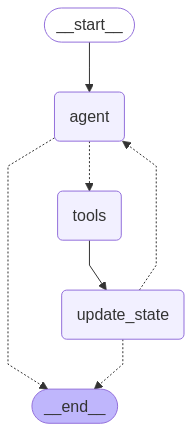

In [14]:
### 13. Graph Definition and Routing (Handles Asynchronous Nodes)

MAX_ITERATIONS = 10 # Max overall cycles for the hunt
graph_builder = StateGraph(ThreatHunterState)

graph_builder.add_node("agent", agent_node)
graph_builder.add_node("tools", tools_node) # ToolNode handles sync/async tools
graph_builder.add_node("update_state", update_state_node)
logger.info("Nodes added to Threat Hunter graph builder (Optimized Version).")

graph_builder.add_edge(START, "agent")

# Conditional edge from agent
def decide_after_agent(state: ThreatHunterState) -> Literal["tools", "__end__"]:
 last_message = state['messages'][-1] if state['messages'] else None
 if isinstance(last_message, AIMessage) and last_message.tool_calls:
  # Check iteration limit (managed by the outer loop, but good for graph logic too)
  if state.get("iterations", 0) < MAX_ITERATIONS: # Iterations here is from the state *before* agent call
   return "tools"
  else:
   logger.warning("Decide_after_agent: Max iterations reached based on state. Ending.")
   return END
 logger.info("Decide_after_agent: No tool calls from LLM, or LLM error. Ending.")
 return END

graph_builder.add_conditional_edges("agent", decide_after_agent) # Simplified conditional edge

graph_builder.add_edge("tools", "update_state")

# Conditional edge from update_state
def decide_after_update(state: ThreatHunterState) -> Literal["agent", "__end__"]:
 if state.get("finished", False):
  logger.info("Decide_after_update: 'finished' flag is True. Ending.")
  return END
 # Iteration check here uses the count *after* a full cycle potentially
 if state.get("iterations", 0) >= MAX_ITERATIONS: # iterations is updated by the outer loop
  logger.warning(f"Decide_after_update: Max iterations ({state.get('iterations',0)}/{MAX_ITERATIONS}) reached. Ending.")
  return END
 return "agent"

graph_builder.add_conditional_edges("update_state", decide_after_update)

logger.info("Edges and conditional edges defined for Threat Hunter graph (Optimized Version).")

threat_hunter_app = None
if llm_with_tools:
 try:
  threat_hunter_app = graph_builder.compile()
  logger.info("Threat Hunter LangGraph (Optimized Version) compiled successfully.")
  try:
   # Visualization might require 'mermaid' CLI or specific libraries
   display(Image(threat_hunter_app.get_graph().draw_mermaid_png()))
   # logger.info("Threat Hunter graph visualization generated (if dependencies met).")
   pass # Mermaid viz can be flaky in some envs, make optional
  except Exception as viz_error:
   logger.warning(f"Could not generate graph visualization: {viz_error} (mermaid executable or other dep might be missing)")
 except Exception as compile_error:
  logger.exception("Failed to compile Threat Hunter LangGraph (Optimized Version).")
  print(f"ERROR: Failed to compile graph: {compile_error}")
else:
 logger.error("Graph compilation skipped because LLM is not available.")
 print("ERROR: Graph compilation skipped because LLM is not available.")


In [15]:
### 14. Running the Threat Hunter Agent (Asynchronous)

async def run_threat_hunt(initial_goal: str):
 """Initiates and runs the asynchronous threat hunting process for a given goal."""
 if not threat_hunter_app:
  logger.error("Threat Hunter App not compiled. Cannot run hunt.")
  print("ERROR: Threat Hunter App not compiled. Cannot run hunt.")
  return
 if not GOOGLE_API_KEY: # Redundant check, but good for safety
  logger.error("GOOGLE_API_KEY not configured. Cannot run hunt.")
  print("ERROR: GOOGLE_API_KEY not configured. Cannot run hunt.")
  return

 logger.info(f"--- Starting Async Threat Hunt (Optimized Version) ---")
 print(f"\n🎯 Initial Goal: {initial_goal}\n")
 print("-" * 40)

 current_state = ThreatHunterState(
  messages=[HumanMessage(content=f"Start investigating based on this goal: {initial_goal}")],
  initial_goal=initial_goal,
  current_hypothesis="Investigating initial goal.",
  indicators=[],
  evidence=[],
  plan=[],
  executed_steps=[],
  finished=False,
  iterations=0
 )

 config = {"recursion_limit": 150} # Standard LangGraph config

 try:
  while not current_state.get("finished", False) and current_state.get("iterations", 0) < MAX_ITERATIONS:
   iter_count = current_state.get("iterations", 0)
   logger.info(f"--- Invoking Async Graph: Iteration {iter_count} ---")
   print(f"\n--- Invoking Async Graph: Iteration {iter_count} ---")

   # Asynchronously invoke the graph
   # The 'iterations' in current_state is what's passed TO the graph for this cycle
   step_output_state = await threat_hunter_app.ainvoke(current_state, config=config)
   
   # Update current_state with the full output state from the graph cycle
   current_state = step_output_state

   print(f" State After Iteration {iter_count}:")
   last_msg = current_state['messages'][-1] if current_state['messages'] else None
   if isinstance(last_msg, AIMessage):
    print(f" AI Thought/Action:\n{last_msg.content[:500]}{'...' if len(last_msg.content) > 500 else ''}")
    if last_msg.tool_calls: print(f" AI Tool Calls: {[tc.get('name', 'N/A') for tc in last_msg.tool_calls]}")
   elif isinstance(last_msg, ToolMessage):
    print(f" Tool '{last_msg.name}' Result (Preview): {last_msg.content[:300]}...")
   
   print(f" Indicators: {len(current_state.get('indicators',[]))}, Evidence: {len(current_state.get('evidence',[]))}, Finished: {current_state.get('finished')}")
   print("-" * 40)

   # CRUCIAL: Increment iteration count *after* a full graph cycle for the *outer loop* control
   current_state['iterations'] = iter_count + 1


   if current_state.get("finished", False):
    logger.info("Hunt marked as finished in state after graph cycle.")
    break
   if current_state.get("iterations", 0) >= MAX_ITERATIONS:
    logger.warning("Max iterations reached after graph cycle.")
    print("\nWARN: Maximum iterations reached. Ending hunt.")
    break
   
   await asyncio.sleep(0.2) # Small delay for readability / API rate limits

 except KeyboardInterrupt:
  print("\nThreat Hunt interrupted by user.")
  logger.warning("Threat Hunt interrupted by user (KeyboardInterrupt).")
 except Exception as e:
  logger.exception(f"An error occurred during the async threat hunt: {e}")
  print(f"\n🚨 An error occurred during the hunt: {str(e)}\nTraceback:\n{e.__traceback__}")
  # You might want to print more details from e or its traceback for debugging

 logger.info("--- Async Threat Hunt Finished ---")
 print("\n--- Async Threat Hunt Finished ---")

 # Display the final report
 if current_state and 'evidence' in current_state:
  final_report_evidence_item = next((ev for ev in reversed(current_state['evidence']) if ev.get('tool_name') == 'generate_report'), None)
  if final_report_evidence_item:
   try:
    report_data_output = final_report_evidence_item.get('output', {})
    # Output from generate_report is already a dict
    # report_preview_str = report_data_output.get("report_preview", "N/A")
    
    # Reconstruct the full report content for display based on final state,
    # as 'generate_report' only returns a preview.
    # The LLM is supposed to call generate_report with the final hypothesis, evidence summary etc.
    # For a true display, you'd parse the *inputs* to the generate_report call or the final state's hypothesis.
    # Here, we'll use the preview as a proxy if direct parsed inputs are complex to get from messages.
    # A more robust way is to have generate_report store its inputs into the state.
    
    # Let's try to pull the *actual data used for the report* from the messages
    # This is a bit complex, assumes AIMessage -> tool_calls -> generate_report with args
    report_content_for_display = "## Threat Hunting Report (Reconstructed from Agent's Final Call)\n\n"
    report_call_args = None
    for msg_idx in range(len(current_state['messages']) -1, -1, -1):
        msg = current_state['messages'][msg_idx]
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                if tc.get('name') == 'generate_report':
                    report_call_args = tc.get('args', {})
                    break
            if report_call_args:
                break
    
    if report_call_args:
        report_content_for_display += f"**Generated (UTC):** {datetime.datetime.now(datetime.timezone.utc).isoformat()}\\n"
        report_content_for_display += f"**Confidence Level:** {report_call_args.get('confidence', 'N/A')}\\n\\n"
        report_content_for_display += f"**Final Hypothesis:**\\n{report_call_args.get('final_hypothesis', 'N/A')}\\n\\n"
        
        sup_ev = report_call_args.get('supporting_evidence', [])
        report_content_for_display += f"**Key Supporting Evidence (from agent's call):**\\n"
        if sup_ev:
            for i, ev_item in enumerate(sup_ev[:5]): # Show max 5 from args
                report_content_for_display += f"- Evidence {i+1}: {str(ev_item)[:300]}...\n"
        else: report_content_for_display += "- None detailed in call.\\n"
        
        rec_actions = report_call_args.get('recommended_actions', [])
        report_content_for_display += f"\\n**Recommended Actions:**\\n"
        if rec_actions:
            for action in rec_actions: report_content_for_display += f"- {action}\\n"
        else: report_content_for_display += "- None specified in call.\\n"
    else:
        # Fallback to the preview from tool output if args not found
        report_content_for_display = report_data_output.get("report_preview", "Could not reconstruct full report. No args found.")


    print("\nFinal Report:")
    display(Markdown(report_content_for_display))
   except Exception as report_display_error:
    logger.error(f"Failed to display final report from evidence: {report_display_error}")
    print(f"\nCould not display final report from evidence: {report_display_error}")
  else:
   print("\nNo final report (tool 'generate_report') evidence found in the final state.")
 else:
  print("\nFinal state not available or no evidence to check for report.")



In [16]:
# --- Example Hunt (Run Asynchronously) ---
hunt_goal = ("Investigate multiple failed login attempts for the 'admin' user "
             "on 'webserver-prod' followed by a suspicious web request "
             "containing SQL syntax from the source IP '203.0.113.15'. Check if this IP is known malicious.")

# To run in a Jupyter Notebook cell that supports top-level await:
await run_threat_hunt(hunt_goal)


# --- Second Example Hunt (Optional, Asynchronous) ---
hunt_goal_2 = "Look for signs of unusual user agent 'Nmap Scanner' in web logs and check associated IPs for malicious activity."
await run_threat_hunt(hunt_goal_2)



🎯 Initial Goal: Investigate multiple failed login attempts for the 'admin' user on 'webserver-prod' followed by a suspicious web request containing SQL syntax from the source IP '203.0.113.15'. Check if this IP is known malicious.

----------------------------------------

--- Invoking Async Graph: Iteration 0 ---
 State After Iteration 0:
 Tool 'generate_report' Result (Preview): {"status": "Report generation request acknowledged.", "report_preview": "## Threat Hunting Report\\n\\n**Generated (UTC):** 2025-05-06T08:30:21.966960+00:00\\n**Confidence Level:** Medium\\n\\n**Final Hypothesis:**\\nMultiple failed login attempts for the 'admin' user were followed by a potential SQ...
 Indicators: 3, Evidence: 11, Finished: True
----------------------------------------

--- Async Threat Hunt Finished ---

Final Report:


## Threat Hunting Report (Reconstructed from Agent's Final Call)

**Generated (UTC):** 2025-05-06T08:30:21.969133+00:00\n**Confidence Level:** Medium\n\n**Final Hypothesis:**\nMultiple failed login attempts for the 'admin' user were followed by a potential SQL injection attempt from a different IP address. This suggests a possible brute-force attack followed by an attempt to exploit a vulnerability.\n\n**Key Supporting Evidence (from agent's call):**\n- Evidence 1: {'sample_results': [{'timestamp': '2024-03-15T09:35:10', 'hostname': 'webserver-prod', 'event_type': 'login_failed', 'source_ip': '10.0.0.55', 'user': 'admin'}, {'event_type': 'login_failed', 'source_ip': '10.0.0.55', 'user': 'admin', 'hostname': 'webserver-prod', 'timestamp': '2024-03-15T09:35:11'}...
- Evidence 2: {'sample_results': [{'source_ip': '203.0.113.15', 'uri': '/api/users', 'user_agent': 'curl/7.68', 'status_code': 401.0, 'timestamp': '2024-03-15T10:05:05', 'method': 'POST', 'protocol': 'HTTP/1.1'}, {'timestamp': '2024-03-15T10:15:32', 'user_agent': 'sqlmap/1.6', 'uri': '/api/products?id=1 UNION SEL...
- Evidence 3: {'analysis': 'Potential SQL injection attempt detected in web logs.', 'potential_techniques': ['T1190', 'T1078', 'T1566', 'T1059.003', 'T1219']}...
\n**Recommended Actions:**\n- Investigate the source IP addresses for malicious activity.\n- Review web server logs for other potential exploits.\n- Implement rate limiting and strong password policies.\n- Patch any identified vulnerabilities.\n


🎯 Initial Goal: Look for signs of unusual user agent 'Nmap Scanner' in web logs and check associated IPs for malicious activity.

----------------------------------------

--- Invoking Async Graph: Iteration 0 ---
 State After Iteration 0:
 Tool 'generate_report' Result (Preview): {"status": "Report generation request acknowledged.", "report_preview": "## Threat Hunting Report\\n\\n**Generated (UTC):** 2025-05-06T08:30:28.250832+00:00\\n**Confidence Level:** Medium\\n\\n**Final Hypothesis:**\\nNmap scanner detected probing the web server. The IP address 198.51.100.88 was iden...
 Indicators: 1, Evidence: 5, Finished: True
----------------------------------------

--- Async Threat Hunt Finished ---

Final Report:


## Threat Hunting Report (Reconstructed from Agent's Final Call)

**Generated (UTC):** 2025-05-06T08:30:28.252931+00:00\n**Confidence Level:** Medium\n\n**Final Hypothesis:**\nNmap scanner detected probing the web server. The IP address 198.51.100.88 was identified as the source. The scanner accessed /robots.txt, resulting in a 404 error. This could be reconnaissance activity.\n\n**Key Supporting Evidence (from agent's call):**\n- Evidence 1: {'query_filter': "user_agent == 'Nmap Scanner'", 'sample_results': [{'protocol': 'HTTP/1.1', 'user_agent': 'Nmap Scanner', 'timestamp': '2024-03-15T10:08:45', 'source_ip': '198.51.100.88', 'uri': '/robots.txt', 'status_code': 404.0, 'method': 'GET'}], 'log_source': 'web_logs', 'match_count': 1.0}...
\n**Recommended Actions:**\n- Investigate the source IP address 198.51.100.88 for other malicious activity.\n- Review web server logs for other suspicious activity from this IP address.\n- Consider blocking the IP address if further malicious activity is detected.\n